In [99]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import os, re, time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, recall_score, precision_score, f1_score

import matplotlib.pyplot as plt
#%matplotlib inline

#1. PCA Analysis
DATA_SET_DIR = '../DATA/DATA_SET'
FILE_END = '.bed.csv'
DATA_TYPE = {'MAX': '_K_max', 'MIN': '_K_min', 'METHY': '_methylation'}
DATA_TYPE_ARR = ['MIN', 'MAX', 'METHY']
K_LEN = [1, 3, 5]
INDEX_NAME = 'Indexs'
INDEX_DIR = os.path.join(DATA_SET_DIR, INDEX_NAME)
CHROMOSOMES = [str(i) for i in range(1, 23)]
CLASSES = [0, 1, 2, 3]
CLASSES_LABELS = ['NON', 'Ecto DMR', 'Endo DMR', 'Meso DMR']
#COLORS = ['r', 'g', 'b', 'k']
COLORS = ['b', 'r', 'r', 'r']
RANDOM_STATE = 42
TEST_RATIO = 0.33

In [92]:
def read_single_csv_data(data_dir, k_len, data_type, chr_i):
    input_fp = os.path.join(data_dir, str(k_len), str(k_len) + DATA_TYPE[data_type], 'chr' + chr_i + ".csv")
    data_pd = pd.read_csv(input_fp, sep=',', header=None).values.astype(float)
    S_COL = 2
    COL_INDEXS = [i for i in range(S_COL, S_COL + 2* k_len)] if data_type == 'METHY' else list(np.array([[S_COL, S_COL + 2 * k_len] for i in range(0,k_len)]).flatten())
    x = data_pd[:, COL_INDEXS]
    y = data_pd[:, -1]
    return [x, y]

In [95]:
def read_data():
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    OUT_DIR = '../DATA/MINI_DATA_SET'
    for k_i, klen in enumerate(K_LEN):
        for d_i, datatype in enumerate(DATA_TYPE_ARR):
            c_x1, c_x2, c_y1, c_y2 = np.array([]), np.array([]), np.array([]), np.array([])
            for chr_i in CHROMOSOMES:
                x, y = read_single_csv_data(OUT_DIR, klen, datatype, chr_i)
                train_len = int(x.shape[0] * (1.0 - TEST_RATIO))
                c_x1 = np.concatenate((c_x1, x[0 : train_len, :]), axis=0) if c_x1.size != 0 else x[0 : train_len, :]
                c_y1 = np.concatenate((c_y1, y[0 : train_len]), axis=0) if c_y1.size != 0 else y[0 : train_len]

                c_x2 = np.concatenate((c_x2, x[train_len : -1, :]), axis=0) if c_x2.size != 0 else x[train_len : -1, :]
                c_y2 = np.concatenate((c_y2, y[train_len : -1]), axis=0) if c_y2.size != 0 else y[train_len : -1]
            x_train.append(c_x1)
            y_train.append(c_y1)
            x_test.append(c_x2)
            y_test.append(c_y2)
    return [x_train, y_train, x_test, y_test]

In [96]:
x_train, y_train, x_test, y_test = read_data()

In [100]:
def plot_pca():
    data_ind = 0
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    for k_i, klen in enumerate(K_LEN):
        for d_i, datatype in enumerate(DATA_TYPE_ARR):
            x = x_train[data_ind]
            x = StandardScaler().fit_transform(x)
            pca = PCA(n_components=2)
            pc = pca.fit_transform(x)
            y = y_train[data_ind]
            data_ind += 1
            ax = axs[k_i, d_i]
            for target, color in zip(CLASSES, COLORS):
                indexs = y == target
                ax.scatter(pc[indexs, 0], pc[indexs, 1], c=color, s=10)

            ax.set_xlabel('PC1', fontsize=8)
            ax.set_ylabel('K,d:' + str(klen) + ' PC2', fontsize=8)
            ax.set_title(datatype, fontsize=8)
            ax.legend(CLASSES_LABELS)
            ax.grid()

    plt.savefig('../FIGURES/PCA.png', dpi=200)
    plt.show()

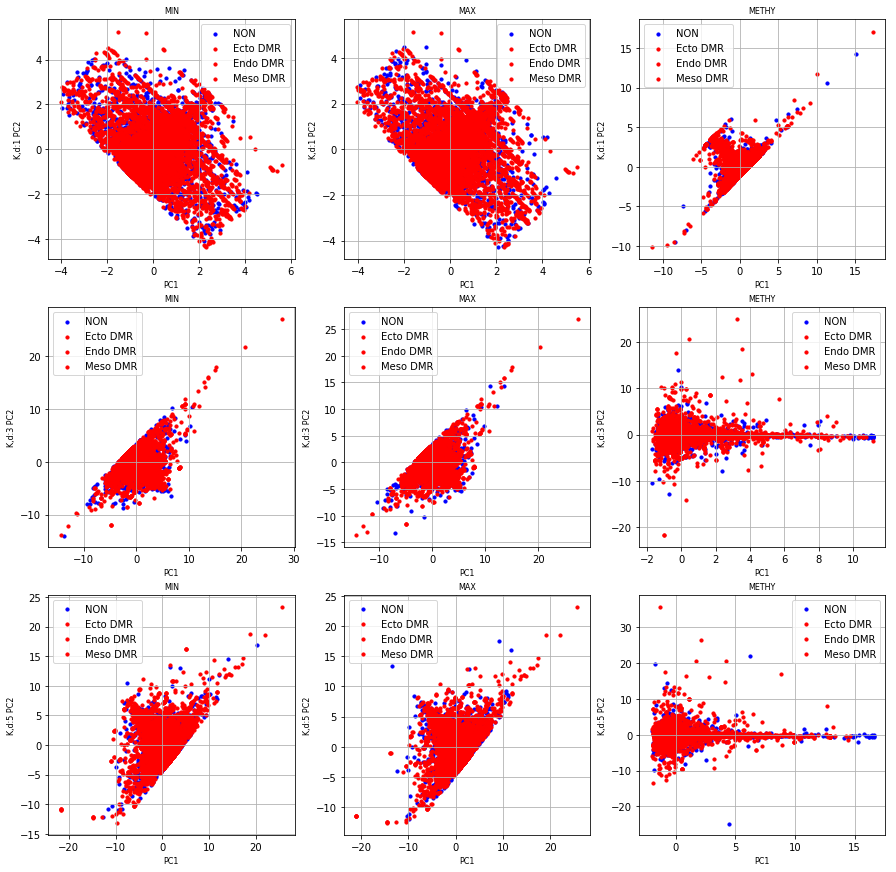

In [101]:
plot_pca()

In [88]:
def plot_tsne():
    data_ind = 0
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    for k_i, klen in enumerate(K_LEN):
        for d_i, datatype in enumerate(DATA_TYPE_ARR):
            x = x_train[data_ind]
            time_start = time.time()
            tsne = TSNE(n_components=2, perplexity=10, n_iter=250)
            pc = tsne.fit_transform(x)
            print('t-SNE %d in %.2f seconds'%(data_ind, time.time() - time_start))
            y = y_train[data_ind]
            data_ind += 1
            ax = axs[k_i, d_i]
            for target, color in zip(CLASSES, COLORS):
                indexs = y == target
                ax.scatter(pc[indexs, 0], pc[indexs, 1], c=color, s=10)

            ax.set_xlabel('TSNE 1', fontsize=8)
            ax.set_ylabel('K,d:' + str(klen) + ' TSNE 2', fontsize=8)
            ax.set_title(datatype, fontsize=8)
            ax.legend(CLASSES_LABELS)
            ax.grid()

    plt.savefig('../FIGURES/TSNE.png', dpi=200)
    plt.show()

t-SNE 0 in 52.29 seconds
t-SNE 1 in 52.20 seconds
t-SNE 2 in 56.22 seconds
t-SNE 3 in 52.17 seconds
t-SNE 4 in 51.70 seconds
t-SNE 5 in 54.51 seconds
t-SNE 6 in 50.79 seconds
t-SNE 7 in 54.85 seconds
t-SNE 8 in 77.70 seconds


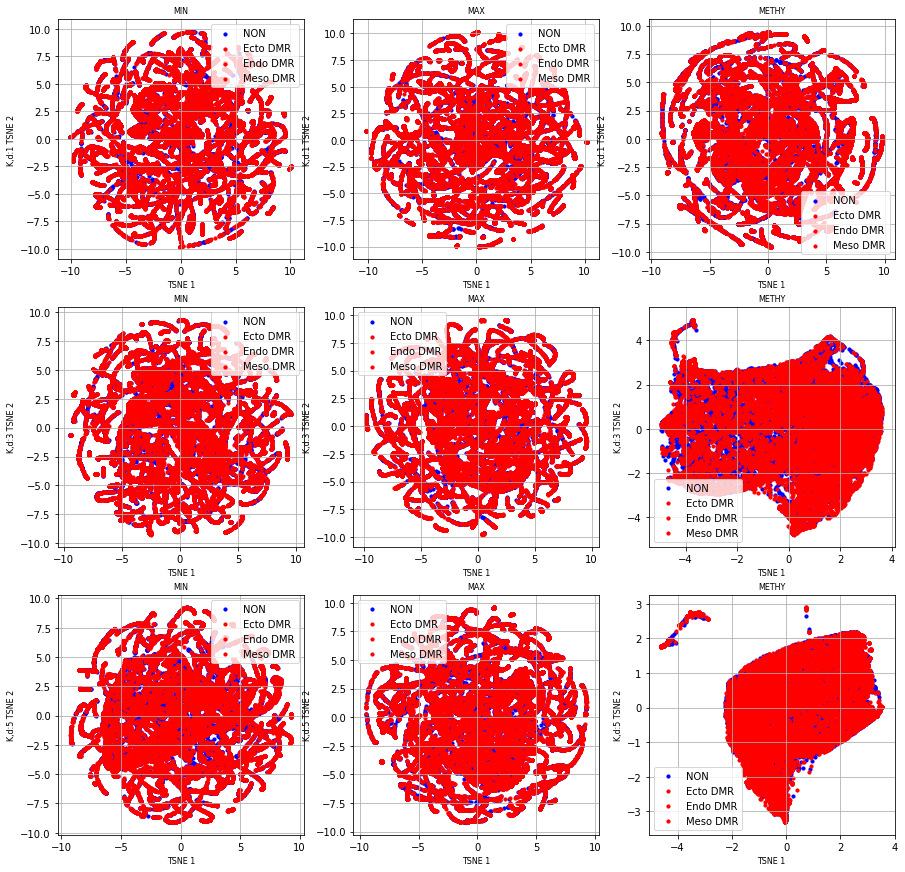

In [89]:
plot_tsne()